# COMP 767 Assignment 
## Yue Dong (260408330) and Ali Emami 
### Please note that all of our figures other than the ones generated in our experiments are from Sutton's book [1].
In this project, our intended object is to experiment with $\beta$-model for a mixture time-scale model prediction. While we were reading the paper "TD Models: Modeling the world with a Mixture of Time Scales", we started to experiment with TD($\lambda$) models and found it is very interesting. In this assignment, we present the work of using TD($\lambda$) to do policy evaluation for one-step models of wall-following and random walks. We will investigate the performance of TD($\lambda$) and Dyna on $\beta$-model in the next assignment. 

# 1. Introduction 
Fix a policy $\pi$ and generate some sample episodes based on $\pi$, consider the task of estimating $V^\pi$ from these sample episodes. For each state $i$, Monte Carlo methods wait for the entire sequence of rewards (return) from state $i$ to the termination before performing a backup. 

$$V(s_t) \leftarrow V(S_t)+ \alpha (R_t - V(s_t))$$
where $R_t$ is the return from $t$ for one episode and $\alpha$ is the step size. 

On the other hand, TD(0) perform updates based on one step reward and the estimate value of the state one step later. 
$$V(s_t) \leftarrow V(s_t)+\alpha [r_{t+1}+\gamma V(s_{t+1}) - V(s_t)]$$

# 2. TD(n): $n$-step TD method

There is no particular reason that why we should only stick with either estimating the value based on one-step reward and the value of the next states or estimating the value based on the return from the whole sequence. In fact, if we observe a sequence of alternating states and rewards, we could use these information to update the target return. More formally, suppose after visiting $s_t$, we observed $r_{t+1},s_{t+1}, r_{t+2}, s_{t+2},..., r_{t+n}, s_{t+n}$, then we could change the target to the so-called "corrected $n$-step truncated return": 

$$R_t^{(n)}=r_{t+1}+\gamma r_{t+2}+\gamma^2r_{t+3}＋...＋\gamma^{n-1}r_{t+n}+\gamma^nV_t(s_{t+n})$$
<img src="n_step_td.png" style="max-width:100%; width: 50%; max-width: none">
Therefore, in the tabular case, an $n$-step backup (on-line or off-line) for $s_t$ is defined by:
$$\Delta V_t(s_t)=\alpha[R_t^{(n)}-V_t(s_t)].$$
For all other states, this value is $\Delta V_t(s)=0$, for all $s \neq s_t$.

These backups can be used by either on-line updating or off-line updating. In on-line updating, $V_{t+1}(s)=V_t(s)+\Delta V_t(s)$ for all $s \in \mathcal{S}$. In off-line updating, we only update $V(s)$ after one episode ends, and the value of the next episode for state $s$ is updated to $V(s)+\sum_{t=0}^{T-1}\Delta V_t(s)$.

We can show that $n$-step methods converge based on the error reduction property of $n$-step returns:
$$max_s|E_{\pi}\{R_t^{(n)}|s_t=s\}-V^{\pi}(s)|\leq \gamma^n max_s|V(s)-V^{\pi}(s)|$$


# 3. TD($\lambda$): weighted average of $n$-step returns

## Forward view (theoretical with $\lambda$-return)
Instead of backing up an $n$-step truncated return, we could also backup an average of several returns with various steps. TD($\lambda$) is such a method for averaging all $n$-step backups (n=1,2,3,...). The target return in TD($\lambda$) is called $\lambda$-return which is defined by:
$$R_t^{\lambda} = (1-\lambda)\sum_{n=1}^{\infty}\lambda^{n-1}R_t^{(n)}=(1-\lambda)\sum_{n=1}^{T-t-1}\lambda^{n-1}R_t^{(n)}+\lambda^{T-t-1}R_t$$

Based on the above formula, we can see that when $\lambda=1$, $R_t^{\lambda}=R_t$ which equals the target of Monte Carlo. When $\lambda=0$, then $R_t^{\lambda}=0^0\times R_t^{(1)}=R_{t+1}+\gamma V(s_{(t+1)})$ which equals the target of TD(0).

<img src="lambda_values.png" style="max-width:100%; width: 100%; max-width: none">

Based on the $\lambda$-return, we therefore define the backup using $\lambda$-return as:
$$\Delta V_t(s_t) = \alpha [ R_t^{\lambda}-V_t(s_t)]$$

The update based on the above equation is called $\lambda$-return algorithm. For the forward view, to update the value function of one state $s_t$, we need to wait for all the rewards and states in the future and decide how to weight them to form the target return $R_t^{\lambda}$. This is illustrated  by the next figure: 
<img src="foward_view.png" style="max-width:100%; width: 100%; max-width: none">

## Backward view (mechanistic with eligibility traces)
The problem of the forward view of TD($\lambda$) is that it is not directly implementable. The backward view of TD($\lambda$) is practical and it can be shown that this mechanism correctly implements the forward view. 

We first define the *eligibility trace* for state $s$ at time $t$ as $e_t(s)\in \mathbb{R}^{+}$. On each step, the eligibility  traces for all states decay by $\gamma \lambda$ except for the one state visited on the step. If the state $s_t$ is visited, its eligibility trace is incremented by 1:
<img src="e_trace.png" style="max-width:100%; width: 30%; max-width: none">
Then the eligibility trace for a particular state can be illustrated as: 
<img src="e_trace_graph_for_one_state.png" style="max-width:100%; width: 50%; max-width: none">
Therefore, the trace for one state records how recently this state has been visited. This "recently" is also indicating how much the state is eligible for changing the value when one-step TD errors $\delta_t=r_{t+1}+\gamma V_t(s_{t+1})-V_t(s_t)$ occur. In other words, when a global $TD$ error occur, it triggers updates on all recently visited states with the weights decided by their traces: 

$$\Delta V_t(s) = \alpha \delta_t e_t(s), \quad \text{for all} \quad s \in \mathcal{S}$$
The following is a complete algorithm for on-line TD($\lambda $): 
<img src="online_td_lambda.png" style="max-width:100%; width: 50%; max-width: none">
As we could see from the above algorithm, whenever a TD error $\delta_t$ occurs, we look back and propogate the error back on all visited states with weights (depending on the eligibility traces). A graph from Sutton's book illustrates this: 
<img src="backview.png" style="max-width:100%; width: 100%; max-width: none">


# 4. Experiments and implementations of TD($\lambda$)

[-0.41208944695236893, -0.74916534470794538, -0.91464182507860337, -0.9283938978560532, -0.90441125380340204, -0.78237509764755298, -0.86502602097918335, -0.94231622292230899, -0.95835325999703058, -1.0594061166983613, -0.82593099564415007, -0.43430885098668165, 0.099524551736797584, 0.52389713265941418, 0.82059271232230602, 0.81783397389633128, 0.63203768908229141, 0.38130901387735427, 0.16044302902932417]


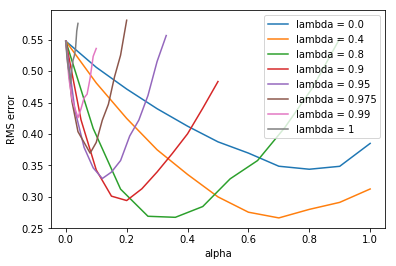

random_walk, 100 runs, 10 episodes per run


In [6]:
# Experiment 1: random walk
#RandomWalkPolicyEvaluation
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 23 14:07:31 2017

@author: user
"""


from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt


N_STATES=19

# discount
GAMMA = 1

# all non terminal states
states = np.arange(1, N_STATES + 1)

# start from 10
START_STATE = 10

# Two terminal states
END_STATES = [0, N_STATES + 1]


# true state value from bellman equation
bellmanStateValues = np.arange(-20, 22, 2) / 20.0
bellmanStateValues[0] = bellmanStateValues[N_STATES + 1] = 0.0


class ValueFunction:
    def __init__(self, Lambda, alpha):
        self.Lambda = Lambda
        self.alpha = alpha
        self.weights = np.zeros(N_STATES + 2)

    #state value is the weights
    def value(self, state):
        return self.weights[state]

    #Feed the algorithm with new observation
    def learn(self, state, reward):
        return

    #Called at the beginning of an episode; initializes variables to reset episode
    def newEpisode(self):
        return

# TD(lambda) algorithm
class TDLambda(ValueFunction):
    def __init__(self, Lambda, alpha):
        ValueFunction.__init__(self, Lambda, alpha)
        self.newEpisode()

    def newEpisode(self):
        #Eligibility trace reset
        self.eligibility = np.zeros(N_STATES + 2)
        #Starting state reset
        self.lastState = START_STATE

    def learn(self, state, reward):
        #Eligibility trace updated
        self.eligibility *= self.Lambda
        self.eligibility[self.lastState] += 1
        #print(self.eligibility)
        delta = reward + self.value(state) - self.value(self.lastState)
        delta *= self.alpha
        self.weights += delta * self.eligibility
        self.lastState = state


# 19-state random walk
def wallFollowing(valueFunction):
    valueFunction.newEpisode()
    currentState = START_STATE
    while currentState not in END_STATES:
        newState = currentState + np.random.choice([-1, 1])
        if newState == 0:
            reward = -1
        elif newState == N_STATES + 1:
            reward = 1
        else:
            reward = 0
        valueFunction.learn(newState, reward)
        currentState = newState

# lambdas is a series of lambda values
# alpha are a sequence of step sizes for each lambda
def RMSResult(TDLambda, runs, lambdas, alphas):

    episodes = 10
    
    #RMS error
    errors = [np.zeros(len(alphas_)) for alphas_ in alphas]
    for run in range(runs):
        for lambdaIndex, Lambda in zip(range(len(lambdas)), lambdas):
            for alphaIndex, alpha in zip(range(len(alphas[lambdaIndex])), alphas[lambdaIndex]):
                valueFunction = TDLambda(Lambda, alpha)
                for episode in range(episodes):
                    #print('run:', run, 'lambda:', Lambda, 'alpha:', alpha, 'episode:', episode)
                    wallFollowing(valueFunction)
                    stateValues = [valueFunction.value(state) for state in states]
                    errors[lambdaIndex][alphaIndex] += np.sqrt(np.mean(np.power(stateValues - bellmanStateValues[1: -1], 2)))

    # average over runs and episodes
    for error in errors:
        error /= episodes * runs
    plt.figure(0)
    for i in range(len(lambdas)):
        plt.plot(alphas[i], errors[i], label='lambda = ' + str(lambdas[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()
    print (stateValues)

# RMSResult: TD(lambda) algorithm
def Experiment():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.99, 0.09),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.33, 0.03),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01),
              np.arange(0, 0.044, 0.004)]

    RMSResult(TDLambda, 100, lambdas, alphas)

Experiment()
x=plt.show()
print ("random_walk, 100 runs, 10 episodes per run")


In [7]:
# Experiment 2: wall following
##WallFollowingPolicyEvaluation
# -*- coding: utf-8 -*-
"""
Created on Tue Feb 21 00:05:59 2017

@author: user
"""

from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from wallfollowing import WallFollowingEnv


def policy_eval(policy, env, discount_factor=0, theta=0.001):
    # Start with 0 value function
    V = np.zeros(env.nS)

    #Define end states (24 is wall, 25 is outside, 26 is exit)
    END_STATES=[24,25,26]

    while True:
        delta = 0
        
        # Do a full back-up for each state
        for s in range(env.nS):

            v = 0
            
            # For all possible actions look at possible next states
            for a, action_prob in enumerate(policy[s]):

                for  prob, next_state, reward, done in env.P[s][a]:
                    
                    #If one, add terminal reward to previous (because we terminate loop on end state)
                    if done:
                        prob, next_state, reward2, done = env.P[next_state][a][0]
                        reward=reward2+reward
                    
                    if s not in END_STATES:
                        
                    # Calculate the expected value 
                        v += action_prob * prob * (reward+ discount_factor * V[next_state])

            #Delta denotes how much our value state has changed
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v

        # If delta below theta, stop evaluating
        if delta < theta:
            break
    return np.array(V)
    
env = WallFollowingEnv()
#env=GridworldEnv()

N_STATES=env.nS-3

# discount
GAMMA = 1

# all non terminal states
states = np.arange(0, env.nS-3)

# start from one of the first three starting states.
START_STATE = np.random.choice([0,1,2])

# three terminal states (wall, outside, exit)
END_STATES = [24,25,26]

policy = np.ones([env.nS, env.nA]) / env.nA

# true state value from bellman equation
bellmanStateValues = policy_eval(policy, env, 1)
bellmanStateValues[24]=-1
bellmanStateValues[25]=-1
bellmanStateValues[26]=1


class ValueFunction:
    def __init__(self, Lambda, alpha):
        self.Lambda = Lambda
        self.alpha = alpha
        self.weights = np.zeros(N_STATES + 3)

    #state value is the weights
    def value(self, state):
        return self.weights[state]

    #Feed the algorithm with new observation
    def learn(self, state, reward):
        return

    #Called at the beginning of an episode; initializes variables to reset episode
    def newEpisode(self):
        return

# TD(lambda) algorithm
class TDLambda(ValueFunction):
    def __init__(self, Lambda, alpha):
        ValueFunction.__init__(self, Lambda, alpha)
        self.newEpisode()

    def newEpisode(self):
        #Eligibility trace reset
        self.eligibility = np.zeros(N_STATES + 3)
        #Starting state reset
        self.lastState = np.random.choice([0,1,2])

    def learn(self, state, reward):
        #Eligibility trace updated
        self.eligibility *= self.Lambda
        self.eligibility[self.lastState] += 1
        delta = reward + self.value(state) - self.value(self.lastState)
        delta *= self.alpha
        self.weights += delta * self.eligibility
        self.lastState = state


# 19-state random walk
def wallFollowing(valueFunction):
    valueFunction.newEpisode()
    currentState = np.random.choice([0,1,2])
    env = WallFollowingEnv()
    policy = np.ones([env.nS, env.nA]) / env.nA


    while currentState not in END_STATES:
        
        action_prob=policy[currentState]
        action = np.random.choice(np.arange(len(action_prob)), p=action_prob)
            
        prob, newState, reward, done =env.P[currentState][action][0]

        if done:
            prob, newState, reward2, done =env.P[newState][action][0]
            valueFunction.learn(newState, reward+reward2)
        else:
            valueFunction.learn(newState, reward)
        currentState = newState

# lambdas is a series of lambda values
# alpha are a sequence of step sizes for each lambda
def RMSResult(TDLambda, runs, lambdas, alphas):

    episodes = 10
    
    #RMS error
    errors = [np.zeros(len(alphas_)) for alphas_ in alphas]
    for run in range(runs):
        for lambdaIndex, Lambda in zip(range(len(lambdas)), lambdas):
            for alphaIndex, alpha in zip(range(len(alphas[lambdaIndex])), alphas[lambdaIndex]):
                valueFunction = TDLambda(Lambda, alpha)
                for episode in range(episodes):
                    print('run:', run, 'lambda:', Lambda, 'alpha:', alpha, 'episode:', episode)
                    wallFollowing(valueFunction)
                    stateValues = [valueFunction.value(state) for state in states]
                    errors[lambdaIndex][alphaIndex] += np.sqrt(np.mean(np.power(stateValues - bellmanStateValues[0: 24], 2)))

    # average over runs and episodes
    for error in errors:
        error /= episodes * runs
    plt.figure(0)
    for i in range(len(lambdas)):
        plt.plot(alphas[i], errors[i], label='lambda = ' + str(lambdas[i]))
    plt.xlabel('alpha')
    plt.ylabel('RMS error')
    plt.legend()
    print (stateValues)

# RMSResult: TD(lambda) algorithm
def Experiment():
    lambdas = [0.0, 0.4, 0.8, 0.9, 0.95, 0.975, 0.99, 1]
    alphas = [np.arange(0, 1.1, 0.1),
              np.arange(0, 1.1, 0.1),
              np.arange(0, 0.99, 0.09),
              np.arange(0, 0.55, 0.05),
              np.arange(0, 0.33, 0.03),
              np.arange(0, 0.22, 0.02),
              np.arange(0, 0.11, 0.01),
              np.arange(0, 0.044, 0.004)]

    RMSResult(TDLambda, 100, lambdas, alphas)

Experiment()
plt.show()
print ("wall_following, 100 runs, 10 episodes per run")

ImportError: No module named wallfollowing

# 5. Results

<img src="wall_following_1.png" style="max-width:100%; width: 70%; max-width: none">
<img src="wall_following_2.png" style="max-width:100%; width: 70%; max-width: none">
<img src="wall_following_3.png" style="max-width:100%; width: 70%; max-width: none">
<img src="wall_following_4.png" style="max-width:100%; width: 70%; max-width: none">



# 6. Conclusion and Discussion
## Why are intermediate values of lambda doing best in our examples?

- $\lambda$ determines the extent to which the prediction values for previous
observations are updated by errors in the current step
-TD(0) requires more experiments (in cases like random walk and
wall-following) to assign “real” values to value function (must
propagate n steps back from terminal reward), that is, these state
values are updated less by the errors occurring on the current step.

- TD($\lambda$ =1) requires less experiments to update the state values to
approach the real state values, but is sensitive to step size, alpha,
where an alpha too high will cause oscillation in parameters.

- $\lambda$= 1, supervised method using observation-outcome pairs as training set.

- $\lambda$ = 0, supervised method using training pairs consisting of states
and predictions made on the immediately following state.

-Conceptually, intermediate values of lambda result in an update rule
lying between these two extremes (and for most tasks these would be
most efficient)

# Reference 
[1] Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. Vol. 1. No. 1. Cambridge: MIT press, 1998.